In [ ]:
!pip install matplotlib networkx

In [3]:
from typing import Optional, Dict, Set, List, Tuple, Callable, Any
from collections import defaultdict
from pathlib import Path

import networkx as nx
from matplotlib import pyplot as plt

In [4]:
class TreeNode:
    """ Class for storing recursively tree structures """
    TREE_DISTANCE = 2

    def __init__(self, name: str, *, x: int = 0, y: int = 0, children: Optional[List[Any]] = None): 
        self.x: int = x
        self.y: int = y
        self.name: str = name
        self.children: List[TreeNode] = children if children is not None else []

    def __call__(self, handler: Callable[[Any], None]) -> None:
        self.traverse(handler)

    def layered_tree_draw(self, depth: int = 0):
        """ Initialize tree nodes with coordinates according to "Layerd tree algorithm """
        self.y = depth
        if not self.children:
            return
        
        for child in self.children:
            child.layered_tree_draw(depth + 1)
        
        for i in range(1, len(self.children)):
            left_child = self.children[i - 1]
            right_child = self.children[i]
            right_boundary_left_child = left_child.right_boundary_x
            left_boundary_right_child = right_child.left_boundary_x
            
            delta = right_boundary_left_child - left_boundary_right_child + self.TREE_DISTANCE
            right_child.shift_x(delta)
        
        left_contour_boundary = self.children[0].left_boundary_x
        right_contour_boundary = self.children[-1].right_boundary_x
        mid = (left_contour_boundary + right_contour_boundary) // 2
        self.x = mid

    def check_layered_tree_draw(self) -> None:
        """ Check result of layered tree algorithm """
        if not self.children:
            return
        
        child_pairs = zip(self.children[:-1], self.children[1:])
        for t1, t2 in child_pairs:
            d = self.distance(t1, t2)
            assert d == self.TREE_DISTANCE, f"Check layered tree draw failed. Unexpected tree distance: {d} between {t1.name} and {t2.name}. Must be {self.TREE_DISTANCE}"

    def traverse(self, handler: Callable[[Any], None]) -> None:
        """ Child priority traverse of tree from left to right """
        for child in self.children:
            child.traverse(handler)
        handler(self)

    def shift_x(self, delta: int) -> None:
        """ Shift the whole tree by delta along horizontal axes """
        def shift_node(t: TreeNode) -> TreeNode:
            t.x += delta

        self.traverse(shift_node)

    def shift_y(self, delta: int) -> None:
        """" Shift the whole tree by delta along vertical axes """
        def shift_node(t: TreeNode) -> TreeNode:
            t.y += delta

        self.traverse(shift_node)

    @property
    def left_boundary_x(self) -> int:
        """ The most left boundary of the tree's contour coordinate """
        if not self.children:
            return self.x
        
        child_boundaries = [child.left_boundary_x for child in self.children]
        return min(self.x, *child_boundaries)

    @property
    def right_boundary_x(self) -> int:
        """ The most right boundary of the tree's contour coordinate """
        if not self.children:
            return self.x
        
        child_boundaries = [child.right_boundary_x for child in self.children]
        return max(self.x, *child_boundaries)

    @staticmethod
    def distance(t1: Any, t2: Any) -> int:
        """ Claculate distance between 2 tree: t1 and t2 """
        if t1.left_boundary_x < t2.left_boundary_x < t1.right_boundary_x or t2.left_boundary_x < t1.left_boundary_x < t2.right_boundary_x:
            return 0
        
        left_tree = t1 if t1.left_boundary_x < t2.left_boundary_x else t2
        right_tree = t2 if left_tree is t1 else t1

        return right_tree.left_boundary_x - left_tree.right_boundary_x


In [6]:
# Typedefs 
Edge = Tuple[str, str]
ShallowTree = Dict[str, Set[str]]

class CheckHandler:
    """ Callable class for checking our builded tree """
    def __init__(self):
        self.vertecies: Set[str] = set()

    def __call__(self, t: TreeNode):
        assert t.name not in self.vertecies, f"Invalid tree: vertex {t.name} has been already visited"
        self.vertecies.add(t.name)


class DirectedTreeGraph:
    """ Manager for reading, building and drawing directed tree graphs """
    EMPTY_TREE_NAME = "none"

    def __init__(self, *, path_: Optional[Path] = None, tree: Optional[ShallowTree] = None):
        self.tree: TreeNode = TreeNode(self.EMPTY_TREE_NAME)
        self._edges: List[Edge] = []
        self._vertecies: Set[str] = set()

        if path_:
            self._load_edges_from_graphml(path_)
            self._init_tree_from_edges()
        elif tree:
            self._init_tree_from_dict(tree)
        else:
            raise Exception("Not enough argumetns were provided")

        self._check_tree()

    def print_tree(self):
        """ Debug funcation for printing tree recursively """
        def handler(t: TreeNode):
            print(f"Node = {t.name}, x = {t.x} and y = {t.y}")
        self.tree(handler)

    def draw(self, **kwargs):
        """ Draw tree graphs using pyplot from matplotlib  """
        self.tree.layered_tree_draw()
        self.tree.check_layered_tree_draw()

        plt.figure(**kwargs)
        plt.grid()
        def plot(t: TreeNode):
            x, y = t.x, t.y 
            for child in t.children:
                # Here we use "-" to flip the graph
                plt.plot([x, child.x], [-y, -child.y], "bo-")
        self.tree(plot)

    def _check_tree(self):
        check_handler = CheckHandler()
        self.tree(check_handler)
        assert self._vertecies == check_handler.vertecies, f"Set of vertecies has difference. Expected: {self._vertecies}, but got {check_handler.vertecies}"

    def _load_edges_from_graphml(self, path_: Path) -> None:
        gr = nx.read_graphml(path_)
        self._edges = list(gr.edges())

    def _init_tree_from_edges(self) -> None:
        if not self._edges:
            self.tree = TreeNode(self.EMPTY_TREE_NAME)
            return
    
        self._vertecies = set([edge[0] for edge in self._edges]) | set([edge[1] for edge in self._edges])
        shallow_tree = self._get_shallow_tree()
        self.tree = self._build_tree(shallow_tree)
    
    def _init_tree_from_dict(self, tree: ShallowTree) -> None:
        self._vertecies = set()
        for key, value in tree.items():
            self._vertecies.add(key)
            self._vertecies |= value
        shallow_tree = defaultdict(set)
        shallow_tree.update(tree)
        self.tree = self._build_tree(shallow_tree)

    def _get_shallow_tree(self) -> ShallowTree:
        tree: ShallowTree = defaultdict(set)
        for from_, to_ in self._edges:
            tree[from_].add(to_)
        return tree

    def _build_tree(self, tree: ShallowTree, root: Optional[str] = None) -> TreeNode:
        if root is None:
            root = self._detect_root(tree)

        if not tree[root]:
            return TreeNode(root)

        children = [self._build_tree(tree, child) for child in tree[root]]
        return TreeNode(root, children=children)

    def _detect_root(self, tree: ShallowTree) -> str:
        """ Calculate root of the tree """
        root = None
        unused_vertecies = self._vertecies.copy()
        stack = []
        while unused_vertecies:
            if not stack:
                stack.append(unused_vertecies.pop())
            
            top = stack[-1]
            if not (tree[top] & unused_vertecies):
                stack.pop()
                root = top
                continue

            for neighbour in tree[top]:
                if neighbour in unused_vertecies:
                    stack.append(neighbour)
                    unused_vertecies.remove(neighbour)

        if stack:
            root = stack[0]
        
        assert root is not None, "root of tree not found"
        return root

In [ ]:
# If you run in colab, please download examples
!mkdir -p tree-examples
!cd tree-examples && for i in `seq 1 6`; do wget https://github.com/NikitaSikalov/DataViz/raw/main/tree-examples/$i.xml; done

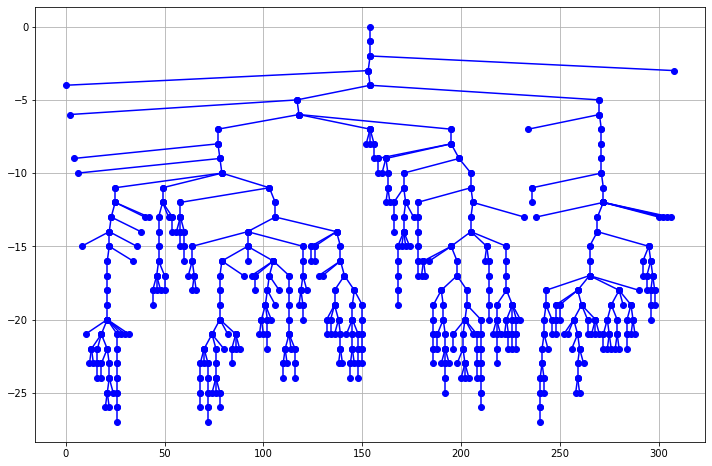

In [164]:
# You can see some more examples trees in ./tree-examples dir (from 1.xml to 6.xml)
tree_graph = DirectedTreeGraph(path_=Path("./tree-examples/5.xml"))

tree_graph.draw(figsize=(12, 8))

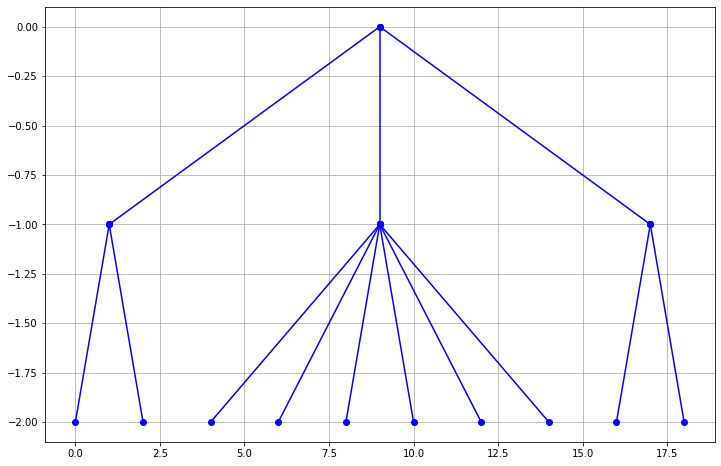

In [11]:
# Also you can try vizualize your own tree with structure ShallowTree (described above)
tree = {
    1: {2, 3, 4},
    4: {6, 7}, 
    2: {10, 11},
    3: {20, 25, 30, 35, 50, 55}
}

tree_graph = DirectedTreeGraph(tree=tree)

tree_graph.draw(figsize=(12, 8))